In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Set seed for reproducibility
np.random.seed(42)

# Constants
num_samples = 5000
sexes = ['Male', 'Female', 'Other']
disciplines = ['Karate', 'Taekwondo', 'MMA', 'Jiu-Jitsu']
injury_types = ['None', 'Muscular', 'Joint', 'Ligament']
fatigue_classes = ['Low', 'Medium', 'High']
recovery_classes = ['Fast', 'Normal', 'Delayed']

# Generate base data
data = {
    # IDs: realistic alphanumeric athlete IDs
    'Athlete ID': ['A' + str(i).zfill(3) for i in np.random.choice(range(1000, 9999), num_samples, replace=False)],

    # Age: mostly young adult martial artists, 18-35 typical
    'Age': np.random.randint(18, 36, num_samples),

    'Sex': np.random.choice(sexes, num_samples, p=[0.7, 0.25, 0.05]),  # mostly male in typical martial arts gyms

    # Weight in kg: typical athletic range for martial arts, depending on discipline, mean ~75kg, std dev ~12
    'Weight': np.round(np.random.normal(75, 12, num_samples), 2),

    # Height in cm: typical range 160-185 cm
    'Height': np.round(np.random.normal(175, 7, num_samples), 2),

    # Training Experience in years: most athletes have 1 to 10 years experience
    'Training Experience (Years)': np.random.randint(1, 11, num_samples),

    'Discipline': np.random.choice(disciplines, num_samples, p=[0.3, 0.3, 0.25, 0.15]),

    # Session Duration in minutes: typical martial arts sessions last 45-90 min
    'Session Duration (min)': np.random.randint(45, 91, num_samples),

    # Session RPE: subjective exertion, usually high intensity (5-10 scale)
    'Session RPE': np.random.randint(5, 11, num_samples),

    # Dates over roughly 1.5 years for variability
    'Date': pd.date_range(start='2023-01-01', periods=num_samples, freq='D')
}

df = pd.DataFrame(data)

# Calculate training load (duration * RPE)
df['Training Load'] = df['Session Duration (min)'] * df['Session RPE']

# Sort for rolling averages by athlete and date
df.sort_values(by=['Athlete ID', 'Date'], inplace=True)

# Acute (7-day) and Chronic (28-day) rolling averages per athlete for Training Load
df['Acute Load (7-day avg)'] = df.groupby('Athlete ID')['Training Load'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df['Chronic Load (28-day avg)'] = df.groupby('Athlete ID')['Training Load'].transform(lambda x: x.rolling(28, min_periods=1).mean())

# Acute to Chronic Workload Ratio (ACWR) - small epsilon to avoid division by zero
df['ACWR'] = df['Acute Load (7-day avg)'] / (df['Chronic Load (28-day avg)'] + 1e-6)

# Physiological Data adjusted for martial arts athletes:

# Heart Rate (avg during training): typically 120-180 bpm during sessions
df['Heart Rate (avg)'] = np.random.randint(120, 180, num_samples)

# Resting Heart Rate: well-trained athletes typically 45-65 bpm
df['Resting HR'] = np.random.randint(45, 66, num_samples)

# HRV (RMSSD): trained athletes often have higher HRV, range ~30-90 ms
df['HRV (RMSSD)'] = np.round(np.random.normal(60, 15, num_samples), 2).clip(20, 100)

# Oxygen Saturation (SpO2): generally high, ~95-99%
df['Oxygen Saturation (SpO2)'] = np.round(np.random.normal(98, 0.7, num_samples), 1).clip(94, 100)

# Body Temperature: slight variation around normal 36.5-37.5 °C, maybe slightly elevated post-training
df['Body Temperature'] = np.round(np.random.normal(37.1, 0.3, num_samples), 2).clip(36, 38)

# Respiratory Rate (breaths/min): resting 12-20, elevated during training 15-30; use mid-range
df['Respiratory Rate'] = np.round(np.random.normal(20, 4, num_samples), 1).clip(12, 30)

# Sleep and Recovery metrics

# Total Sleep Duration (hours): martial artists aiming for recovery might get 6-9 hours
df['Total Sleep Duration'] = np.round(np.random.uniform(6, 9, num_samples), 2)

# Sleep Efficiency (%): good sleepers range ~85-98%
df['Sleep Efficiency (%)'] = np.round(np.random.uniform(85, 98, num_samples), 1)

# Sleep Onset Latency (minutes): typical 5-20 minutes
df['Sleep Onset Latency'] = np.round(np.random.uniform(5, 20, num_samples), 1)

# Number of Awakenings: usually 0-3 per night
df['Number of Awakenings'] = np.random.randint(0, 4, num_samples)

# Subjective Wellness (scale 1-10 or 1-5 as noted)

# Muscle Soreness Score: 1-10, martial artists often have soreness 2-8
df['Muscle Soreness Score'] = np.random.randint(2, 9, num_samples)

# Mood Score: 1-5, usually 3-5 healthy
df['Mood Score'] = np.random.randint(3, 6, num_samples)

# Fatigue Rating: 1-10, average 3-7
df['Fatigue Rating'] = np.random.randint(3, 8, num_samples)

# Sleep Quality Rating: 1-10, typically 5-9
df['Sleep Quality Rating'] = np.random.randint(5, 10, num_samples)

# Motivation to Train: 1-10, usually 6-10 for committed athletes
df['Motivation to Train'] = np.random.randint(6, 11, num_samples)

# Injury Information

# Recent Injury: 20% incidence (as before)
df['Recent Injury'] = np.random.choice([0, 1], num_samples, p=[0.8, 0.2])

# Injury Type conditional on Recent Injury
df['Injury Type'] = df['Recent Injury'].apply(lambda x: np.random.choice(injury_types[1:]) if x else 'None')

# Days Since Last Injury: 1-30 days if injured, else 0
df['Days Since Last Injury'] = df['Recent Injury'].apply(lambda x: np.random.randint(1, 31) if x else 0)

# Pain Score: 5-10 if injured, else 0
df['Pain Score'] = df['Recent Injury'].apply(lambda x: np.random.randint(5, 11) if x else 0)

# Fatigue Score calculation (weighted composite) adjusted for realistic ranges:
df['Fatigue Score'] = (
    0.3 * df['Training Load'] / 100 +  # scaled to keep within range
    3 * df['Muscle Soreness Score'] +
    4 * (10 - df['Sleep Quality Rating']) +
    0.1 * df['Heart Rate (avg)'] +
    np.random.normal(0, 5, num_samples)
).clip(0, 100).round(2)

# Recovery Score (based on inverse fatigue, sleep, HRV, soreness)
df['Recovery Score'] = (
    100 -
    0.5 * df['Fatigue Score'] +
    3 * df['Total Sleep Duration'] +
    0.4 * df['HRV (RMSSD)'] -
    2 * df['Muscle Soreness Score'] +
    np.random.normal(0, 5, num_samples)
).clip(0, 100).round(2)

# Readiness Score: composite indicator
df['Readiness Score'] = (df['Recovery Score'] - 0.4 * df['Fatigue Score']).clip(0, 100).round(2)

# Recovery Time (hours): inversely related to recovery score, scaled 0-10
df['Recovery Time'] = (10 - df['Recovery Score'] / 10).clip(0, 10).round(2)

# Adjust HRV and Resting HR based on fatigue
df['HRV (RMSSD)'] = (df['HRV (RMSSD)'] - 0.08 * df['Fatigue Score']).clip(20, 100).round(2)
df['Resting HR'] = (df['Resting HR'] + 0.04 * df['Fatigue Score']).clip(45, 100).round(0)

# Adjust motivation and mood based on fatigue
df['Mood Score'] = (5 - (df['Fatigue Score'] / 30) + np.random.normal(0, 0.4, num_samples)).clip(1, 5).round(1)
df['Motivation to Train'] = (10 - df['Fatigue Score'] / 15 + np.random.normal(0, 1, num_samples)).clip(1, 10).round(0)

# Injury effects adjustments
df.loc[df['Recent Injury'] == 1, 'Fatigue Score'] += 8
df.loc[df['Recent Injury'] == 1, 'Recovery Score'] -= 12
df.loc[df['Recent Injury'] == 1, 'Readiness Score'] -= 7

# Recalculate fatigue and recovery classes with adjusted bins
df['Fatigue Class'] = pd.cut(df['Fatigue Score'], bins=[-1, 33, 66, 100], labels=fatigue_classes)
df['Recovery Class'] = pd.cut(df['Recovery Time'], bins=[-1, 3, 6, 10], labels=recovery_classes)

# Reset index
df.reset_index(drop=True, inplace=True)

# ----------- Adjustments for LSTM/GRU -------------

# Encode categorical variables
categorical_cols = ['Sex', 'Discipline', 'Injury Type', 'Fatigue Class', 'Recovery Class']
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save encoders if needed later

# Drop non-numeric or non-useful columns for modeling
df.drop(columns=['Athlete ID', 'Date'], inplace=True)

# Normalize all numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Save the preprocessed dataset
df.to_csv('martial_arts_training_data_for_lstm_5000.csv', index=False)

print("Preprocessing complete. Saved as 'martial_arts_training_data_for_lstm.csv'")


Preprocessing complete. Saved as 'martial_arts_training_data_for_lstm.csv'


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer, Multiply, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import shap
import matplotlib.pyplot as plt

# Load preprocessed data
df = pd.read_csv('martial_arts_training_data_for_lstm_5000.csv')

# Separate features and targets
X = df.drop(columns=['Fatigue Class', 'Recovery Class']).values
y_fatigue = df['Fatigue Class'].values
y_recovery = df['Recovery Class'].values

# Convert target labels to categorical (one-hot)
from tensorflow.keras.utils import to_categorical
num_classes_fatigue = len(np.unique(y_fatigue))
num_classes_recovery = len(np.unique(y_recovery))

y_fatigue_cat = to_categorical(y_fatigue, num_classes=num_classes_fatigue)
y_recovery_cat = to_categorical(y_recovery, num_classes=num_classes_recovery)

# Train-test split
X_train, X_test, y_fatigue_train, y_fatigue_test, y_recovery_train, y_recovery_test = train_test_split(
    X, y_fatigue_cat, y_recovery_cat, test_size=0.2, random_state=42, stratify=y_fatigue
)

# Compute class weights for fatigue and recovery classification to handle imbalance
fatigue_labels = np.argmax(y_fatigue_train, axis=1)
recovery_labels = np.argmax(y_recovery_train, axis=1)

class_weights_fatigue = dict(enumerate(compute_class_weight('balanced', classes=np.unique(fatigue_labels), y=fatigue_labels)))
class_weights_recovery = dict(enumerate(compute_class_weight('balanced', classes=np.unique(recovery_labels), y=recovery_labels)))

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        # Compute attention scores
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Monte Carlo Dropout for uncertainty estimation
class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Build multi-output model with attention and MC Dropout
def build_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = MCDropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = MCDropout(0.3)(x)

    # Attention layer
    x_expanded = tf.expand_dims(x, axis=1)  # shape (batch_size, time_steps=1, features)
    att_output = AttentionLayer()(x_expanded)

    # Outputs
    fatigue_output = Dense(num_classes_fatigue, activation='softmax', name='fatigue')(att_output)
    recovery_output = Dense(num_classes_recovery, activation='softmax', name='recovery')(att_output)

    model = Model(inputs=inputs, outputs=[fatigue_output, recovery_output])
    return model

model = build_model(X_train.shape[1])
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'fatigue': 'categorical_crossentropy', 'recovery': 'categorical_crossentropy'},
              loss_weights={'fatigue': 0.6, 'recovery': 0.4},
              metrics=['accuracy'])

# Fit model with class weights combined (weighted average)
class_weight_combined = {
    'fatigue': class_weights_fatigue,
    'recovery': class_weights_recovery
}

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, {'fatigue': y_fatigue_train, 'recovery': y_recovery_train},
                    validation_split=0.1,
                    epochs=50,
                    batch_size=64,
                    class_weight=class_weight_combined,
                    callbacks=[early_stop],
                    verbose=2)

# Evaluate on test set
results = model.evaluate(X_test, {'fatigue': y_fatigue_test, 'recovery': y_recovery_test}, verbose=0)
print(f"\nTest Losses and Accuracy: {results}")

# Predict classes and get uncertainty estimation with MC Dropout
def mc_dropout_predict(model, X, n_iter=30):
    preds = np.array([model.predict(X, verbose=0) for _ in range(n_iter)])
    mean_preds = preds.mean(axis=0)
    std_preds = preds.std(axis=0)
    return mean_preds, std_preds

mean_preds, std_preds = mc_dropout_predict(model, X_test)

# Extract predictions for fatigue and recovery
fatigue_pred_proba = mean_preds[0]
recovery_pred_proba = mean_preds[1]

fatigue_pred = np.argmax(fatigue_pred_proba, axis=1)
recovery_pred = np.argmax(recovery_pred_proba, axis=1)

fatigue_true = np.argmax(y_fatigue_test, axis=1)
recovery_true = np.argmax(y_recovery_test, axis=1)

# Metrics and reports
print("\nFatigue Classification Report:\n", classification_report(fatigue_true, fatigue_pred))
print("\nRecovery Classification Report:\n", classification_report(recovery_true, recovery_pred))

print("Fatigue Accuracy:", accuracy_score(fatigue_true, fatigue_pred))
print("Recovery Accuracy:", accuracy_score(recovery_true, recovery_pred))

# Confusion Matrices
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(confusion_matrix(fatigue_true, fatigue_pred), annot=True, fmt='d', ax=axs[0])
axs[0].set_title("Fatigue Confusion Matrix")
sns.heatmap(confusion_matrix(recovery_true, recovery_pred), annot=True, fmt='d', ax=axs[1])
axs[1].set_title("Recovery Confusion Matrix")
plt.show()

# SHAP Explainability
explainer = shap.KernelExplainer(model.predict, X_train[:100])  # Use subset for speed
shap_values = explainer.shap_values(X_test[:100], nsamples=100)

# Plot summary plot for Fatigue output only (index 0)
feature_names = df.drop(columns=['Fatigue Class', 'Recovery Class']).columns

shap.summary_plot(shap_values[0], X_test[:100], feature_names=feature_names)

# Output prediction uncertainty summary
print("\nPrediction uncertainty (std dev) summary for fatigue:")
print(np.mean(std_preds[0], axis=0))

print("\nPrediction uncertainty (std dev) summary for recovery:")
print(np.mean(std_preds[1], axis=0))


ValueError: One or both target variables have fewer than 2 classes.

<ipython-input-10-1188466360>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


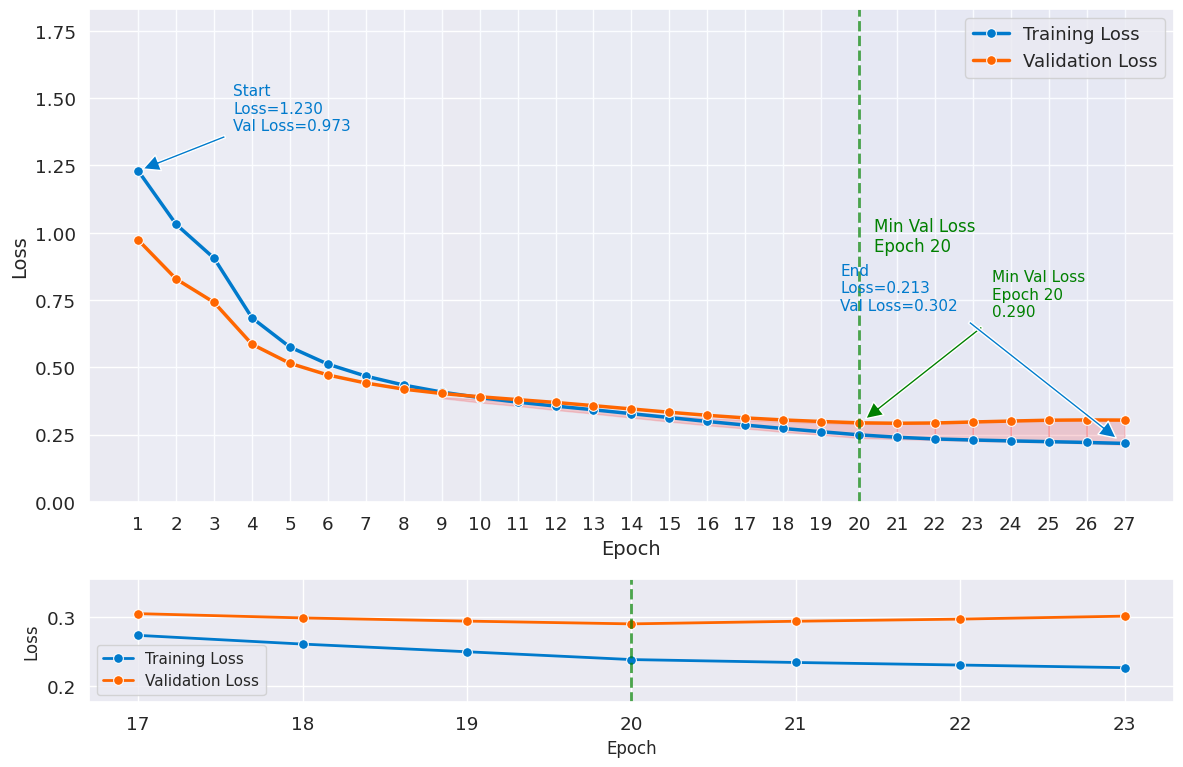

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import gridspec

epochs = np.arange(1, 28)
loss = np.array([1.2301, 0.8325, 0.6542, 0.5653, 0.5072, 0.4638, 0.4320, 0.4074, 0.3861, 0.3701,
                 0.3572, 0.3421, 0.3287, 0.3138, 0.2989, 0.2853, 0.2734, 0.2608, 0.2497, 0.2384,
                 0.2342, 0.2305, 0.2267, 0.2241, 0.2220, 0.2179, 0.2132])
val_loss = np.array([0.9732, 0.6834, 0.5678, 0.5069, 0.4705, 0.4382, 0.4173, 0.4025, 0.3896, 0.3812,
                     0.3705, 0.3579, 0.3456, 0.3337, 0.3212, 0.3114, 0.3048, 0.2986, 0.2940, 0.2900,
                     0.2938, 0.2969, 0.3012, 0.3042, 0.3063, 0.3044, 0.3025])

loss_smooth = pd.Series(loss).rolling(window=3, min_periods=1).mean()
val_loss_smooth = pd.Series(val_loss).rolling(window=3, min_periods=1).mean()

min_val_idx = np.argmin(val_loss)
min_val_epoch = epochs[min_val_idx]
min_val_value = val_loss[min_val_idx]

plt.figure(figsize=(14, 9))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.25)  # increased hspace

ax = plt.subplot(gs[0])

# Background shading for phases
ax.axvspan(1, 9, color="#f0f8ff", alpha=0.2)
ax.axvspan(10, 18, color="#e6f2ff", alpha=0.15)
ax.axvspan(19, 27, color="#cce0ff", alpha=0.1)

sns.set_style('darkgrid')
sns.lineplot(x=epochs, y=loss_smooth, marker='o', color='#007acc', label='Training Loss', linewidth=2.5, markersize=7)
sns.lineplot(x=epochs, y=val_loss_smooth, marker='o', color='#ff6600', label='Validation Loss', linewidth=2.5, markersize=7)

# Highlight overfitting zones
for i in range(len(epochs)-1):
    if val_loss[i] > loss[i]:
        ax.fill_between(epochs[i:i+2], loss[i:i+2], val_loss[i:i+2], color='red', alpha=0.15)

ax.axvline(min_val_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax.text(min_val_epoch + 0.4, max(max(loss), max(val_loss)) - 0.3,
        f'Min Val Loss\nEpoch {min_val_epoch}', color='green', fontsize=12)

# Adjusted annotations with increased spacing
ax.annotate(f'Start\nLoss={loss[0]:.3f}\nVal Loss={val_loss[0]:.3f}',
            xy=(epochs[0], loss[0]), xytext=(epochs[0] + 2.5, loss[0] + 0.15),
            arrowprops=dict(facecolor='#007acc', shrink=0.05, width=2),
            fontsize=11, color='#007acc')

ax.annotate(f'Min Val Loss\nEpoch {min_val_epoch}\n{min_val_value:.3f}',
            xy=(min_val_epoch, min_val_value), xytext=(min_val_epoch + 3.5, min_val_value + 0.4),
            arrowprops=dict(facecolor='green', shrink=0.05, width=2),
            fontsize=11, color='green')

ax.annotate(f'End\nLoss={loss[-1]:.3f}\nVal Loss={val_loss[-1]:.3f}',
            xy=(epochs[-1], loss[-1]), xytext=(epochs[-1] - 7.5, loss[-1] + 0.5),
            arrowprops=dict(facecolor='#007acc', shrink=0.05, width=2),
            fontsize=11, color='#007acc')

ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
#ax.set_title('Training vs Validation Loss Over Epochs\nHighlighting Learning Phases & Overfitting Zones', fontsize=18, fontweight='bold')
ax.legend(fontsize=13)
ax.set_xticks(epochs)
ax.set_ylim(0, max(max(loss), max(val_loss)) + 0.6)

ax_inset = plt.subplot(gs[1])

window = 3
start_inset = max(min_val_idx - window, 0)
end_inset = min(min_val_idx + window + 1, len(epochs))

sns.lineplot(x=epochs[start_inset:end_inset], y=loss[start_inset:end_inset], marker='o',
             color='#007acc', label='Training Loss', ax=ax_inset, linewidth=2, markersize=7)
sns.lineplot(x=epochs[start_inset:end_inset], y=val_loss[start_inset:end_inset], marker='o',
             color='#ff6600', label='Validation Loss', ax=ax_inset, linewidth=2, markersize=7)

ax_inset.axvline(min_val_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)
#ax_inset.set_title('Zoomed View Around Minimum Validation Loss Epoch', fontsize=14, fontweight='bold')
ax_inset.set_xlabel('Epoch', fontsize=12)
ax_inset.set_ylabel('Loss', fontsize=12)
ax_inset.set_xticks(epochs[start_inset:end_inset])
ax_inset.legend(fontsize=11)
ax_inset.grid(True)
ax_inset.set_ylim(min(min(loss[start_inset:end_inset]), min(val_loss[start_inset:end_inset])) - 0.05,
                 max(max(loss[start_inset:end_inset]), max(val_loss[start_inset:end_inset])) + 0.05)

plt.tight_layout()
plt.show()


<ipython-input-13-3196561389>:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


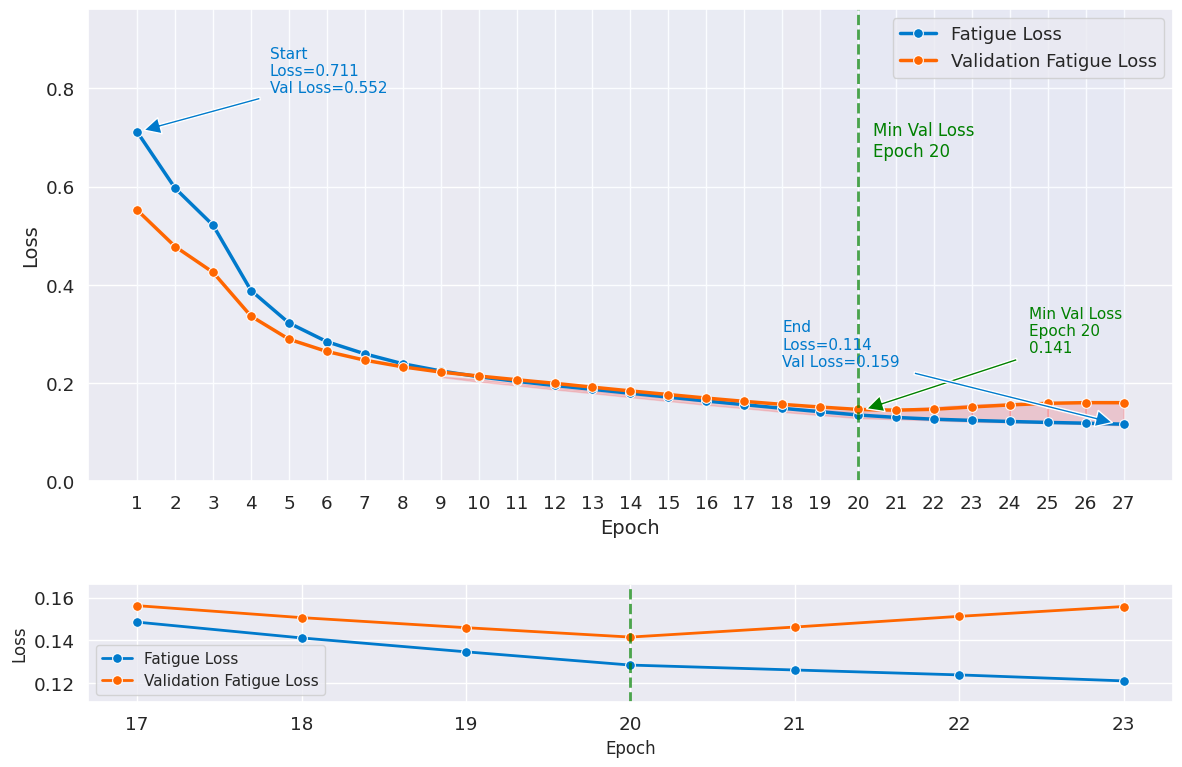

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import gridspec

epochs = np.arange(1, 28)
fatigue_loss = np.array([
    0.7114, 0.4820, 0.3706, 0.3123, 0.2836, 0.2562, 0.2378, 0.2232, 0.2122, 0.2026,
    0.1950, 0.1867, 0.1791, 0.1710, 0.1632, 0.1554, 0.1485, 0.1411, 0.1346, 0.1284,
    0.1261, 0.1238, 0.1210, 0.1195, 0.1181, 0.1162, 0.1135
])

val_fatigue_loss = np.array([
    0.5521, 0.4037, 0.3201, 0.2844, 0.2627, 0.2451, 0.2312, 0.2220, 0.2131, 0.2073,
    0.1992, 0.1912, 0.1837, 0.1763, 0.1690, 0.1621, 0.1562, 0.1506, 0.1459, 0.1415,
    0.1462, 0.1512, 0.1558, 0.1585, 0.1611, 0.1598, 0.1585
])

# Smooth the curves
fatigue_loss_smooth = pd.Series(fatigue_loss).rolling(window=3, min_periods=1).mean()
val_fatigue_loss_smooth = pd.Series(val_fatigue_loss).rolling(window=3, min_periods=1).mean()

min_val_idx = np.argmin(val_fatigue_loss)
min_val_epoch = epochs[min_val_idx]
min_val_value = val_fatigue_loss[min_val_idx]

plt.figure(figsize=(14, 9))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.35)  # increased hspace for more gap

ax = plt.subplot(gs[0])

# Background shading for phases
ax.axvspan(1, 9, color="#f0f8ff", alpha=0.2)
ax.axvspan(10, 18, color="#e6f2ff", alpha=0.15)
ax.axvspan(19, 27, color="#cce0ff", alpha=0.1)

sns.set_style('darkgrid')
sns.lineplot(x=epochs, y=fatigue_loss_smooth, marker='o', color='#007acc', label='Fatigue Loss', linewidth=2.5, markersize=7)
sns.lineplot(x=epochs, y=val_fatigue_loss_smooth, marker='o', color='#ff6600', label='Validation Fatigue Loss', linewidth=2.5, markersize=7)

# Highlight overfitting zones
for i in range(len(epochs)-1):
    if val_fatigue_loss[i] > fatigue_loss[i]:
        ax.fill_between(epochs[i:i+2], fatigue_loss[i:i+2], val_fatigue_loss[i:i+2], color='red', alpha=0.15)

ax.axvline(min_val_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax.text(min_val_epoch + 0.4, max(max(fatigue_loss), max(val_fatigue_loss)) - 0.05,
        f'Min Val Loss\nEpoch {min_val_epoch}', color='green', fontsize=12)

# Annotations with increased spacing to avoid overlap
ax.annotate(f'Start\nLoss={fatigue_loss[0]:.3f}\nVal Loss={val_fatigue_loss[0]:.3f}',
            xy=(epochs[0], fatigue_loss[0]), xytext=(epochs[0] + 3.5, fatigue_loss[0] + 0.08),
            arrowprops=dict(facecolor='#007acc', shrink=0.05, width=2),
            fontsize=11, color='#007acc')

ax.annotate(f'Min Val Loss\nEpoch {min_val_epoch}\n{min_val_value:.3f}',
            xy=(min_val_epoch, min_val_value), xytext=(min_val_epoch + 4.5, min_val_value + 0.12),
            arrowprops=dict(facecolor='green', shrink=0.05, width=2),
            fontsize=11, color='green')

ax.annotate(f'End\nLoss={fatigue_loss[-1]:.3f}\nVal Loss={val_fatigue_loss[-1]:.3f}',
            xy=(epochs[-1], fatigue_loss[-1]), xytext=(epochs[-1] - 9, fatigue_loss[-1] + 0.12),
            arrowprops=dict(facecolor='#007acc', shrink=0.05, width=2),
            fontsize=11, color='#007acc')

ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=13)
ax.set_xticks(epochs)
ax.set_ylim(0, max(max(fatigue_loss), max(val_fatigue_loss)) + 0.25)

ax_inset = plt.subplot(gs[1])

window = 3
start_inset = max(min_val_idx - window, 0)
end_inset = min(min_val_idx + window + 1, len(epochs))

sns.lineplot(x=epochs[start_inset:end_inset], y=fatigue_loss[start_inset:end_inset], marker='o',
             color='#007acc', label='Fatigue Loss', ax=ax_inset, linewidth=2, markersize=7)
sns.lineplot(x=epochs[start_inset:end_inset], y=val_fatigue_loss[start_inset:end_inset], marker='o',
             color='#ff6600', label='Validation Fatigue Loss', ax=ax_inset, linewidth=2, markersize=7)

ax_inset.axvline(min_val_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax_inset.set_xlabel('Epoch', fontsize=12)
ax_inset.set_ylabel('Loss', fontsize=12)
ax_inset.set_xticks(epochs[start_inset:end_inset])
ax_inset.legend(fontsize=11)
ax_inset.grid(True)
ax_inset.set_ylim(min(min(fatigue_loss[start_inset:end_inset]), min(val_fatigue_loss[start_inset:end_inset])) - 0.01,
                 max(max(fatigue_loss[start_inset:end_inset]), max(val_fatigue_loss[start_inset:end_inset])) + 0.01)

plt.tight_layout()
plt.show()


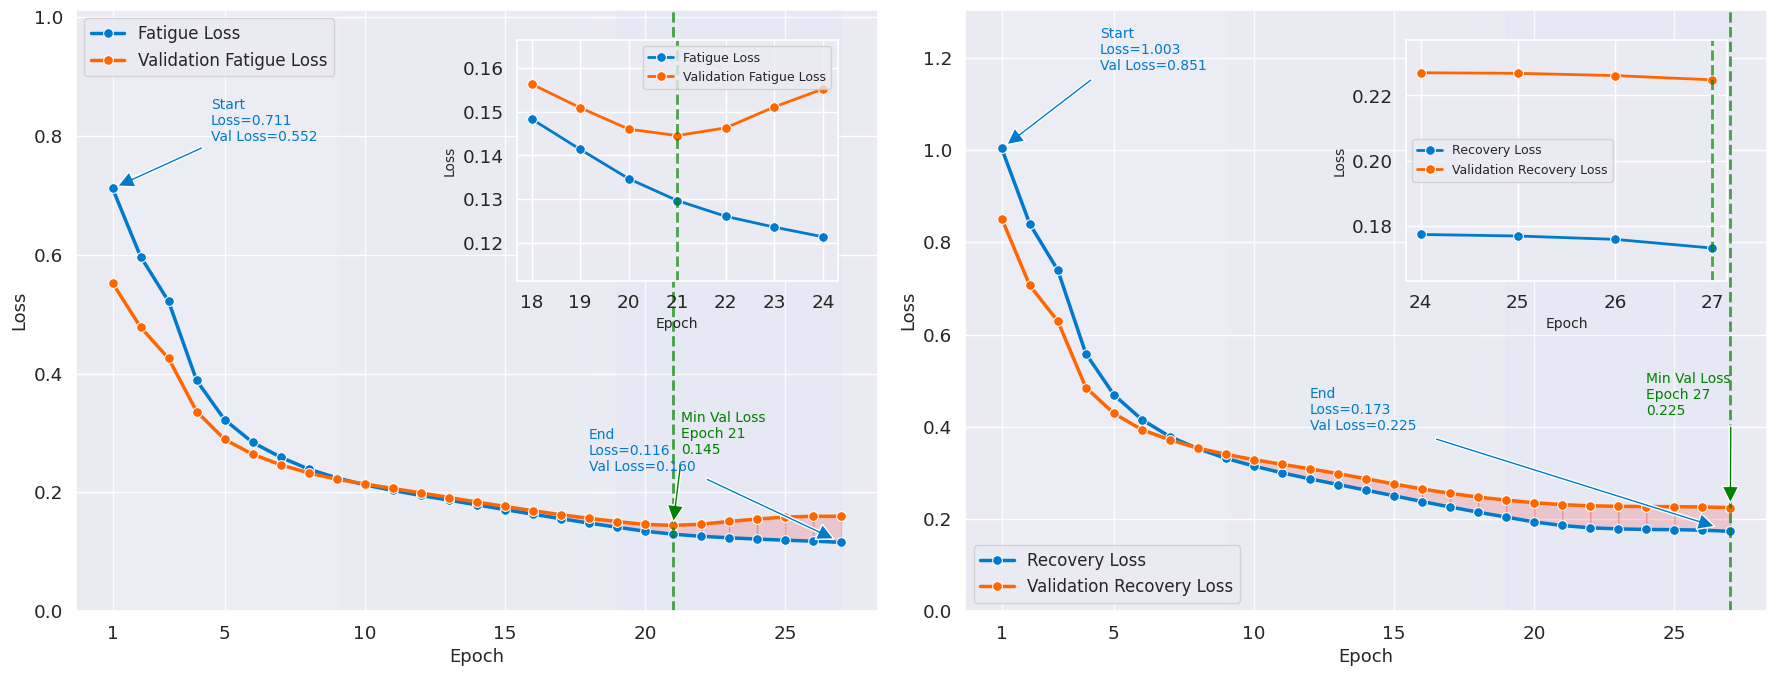

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

epochs = np.arange(1, 28)

# Data
fatigue_loss = np.array([
    0.7114, 0.4820, 0.3706, 0.3123, 0.2836, 0.2562, 0.2378, 0.2232, 0.2122, 0.2026,
    0.1950, 0.1867, 0.1791, 0.1710, 0.1632, 0.1554, 0.1485, 0.1411, 0.1346, 0.1284,
    0.1261, 0.1238, 0.1210, 0.1195, 0.1181, 0.1162, 0.1135
])

val_fatigue_loss = np.array([
    0.5521, 0.4037, 0.3201, 0.2844, 0.2627, 0.2451, 0.2312, 0.2220, 0.2131, 0.2073,
    0.1992, 0.1912, 0.1837, 0.1763, 0.1690, 0.1621, 0.1562, 0.1506, 0.1459, 0.1415,
    0.1462, 0.1512, 0.1558, 0.1585, 0.1611, 0.1598, 0.1585
])

recovery_loss = np.array([
    1.0033, 0.6761, 0.5390, 0.4608, 0.4086, 0.3770, 0.3501, 0.3307, 0.3136, 0.2997,
    0.2869, 0.2744, 0.2629, 0.2503, 0.2376, 0.2256, 0.2150, 0.2036, 0.1938, 0.1835,
    0.1805, 0.1786, 0.1765, 0.1769, 0.1772, 0.1734, 0.1689
])

val_recovery_loss = np.array([
    0.8512, 0.5614, 0.4742, 0.4197, 0.3931, 0.3682, 0.3535, 0.3394, 0.3279, 0.3185,
    0.3094, 0.2985, 0.2872, 0.2761, 0.2644, 0.2548, 0.2475, 0.2405, 0.2350, 0.2302,
    0.2283, 0.2272, 0.2269, 0.2268, 0.2267, 0.2248, 0.2229
])

# Smooth curves (rolling window = 3)
def smooth(arr):
    return pd.Series(arr).rolling(window=3, min_periods=1).mean()

fatigue_loss_smooth = smooth(fatigue_loss)
val_fatigue_loss_smooth = smooth(val_fatigue_loss)

recovery_loss_smooth = smooth(recovery_loss)
val_recovery_loss_smooth = smooth(val_recovery_loss)

# Helper function to plot each subplot
def plot_loss(ax, epochs, train_loss, val_loss, train_label, val_label, is_right_plot=False):
    min_val_idx = np.argmin(val_loss)
    min_val_epoch = epochs[min_val_idx]
    min_val_value = val_loss[min_val_idx]

    # Background shading phases
    ax.axvspan(1, 9, color="#f0f8ff", alpha=0.2)
    ax.axvspan(10, 18, color="#e6f2ff", alpha=0.15)
    ax.axvspan(19, 27, color="#cce0ff", alpha=0.1)

    sns.lineplot(x=epochs, y=train_loss, marker='o', color='#007acc', label=train_label,
                 linewidth=2.5, markersize=7, ax=ax)
    sns.lineplot(x=epochs, y=val_loss, marker='o', color='#ff6600', label=val_label,
                 linewidth=2.5, markersize=7, ax=ax)

    # Overfitting zones
    for i in range(len(epochs) - 1):
        if val_loss[i] > train_loss[i]:
            ax.fill_between(epochs[i:i + 2], train_loss[i:i + 2], val_loss[i:i + 2], color='red', alpha=0.15)

    ax.axvline(min_val_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)

    # Annotation positions
    if is_right_plot:
        # spread annotations vertically to avoid overlap and avoid line overlap
        start_text_pos = (epochs[0] + 3.5, train_loss.iloc[0] + 0.17)  # raised offset here
        min_val_text_pos = (min_val_epoch - 3, min_val_value + 0.20)
        end_text_pos = (epochs[-1] - 15, train_loss.iloc[-1] + 0.22)  # raised offset here
    else:
        start_text_pos = (epochs[0] + 3.5, train_loss.iloc[0] + 0.08)
        min_val_text_pos = (min_val_epoch + 0.3, min_val_value + 0.12)
        end_text_pos = (epochs[-1] - 9, train_loss.iloc[-1] + 0.12)

    # Annotations
    ax.annotate(f'Start\nLoss={train_loss.iloc[0]:.3f}\nVal Loss={val_loss.iloc[0]:.3f}',
                xy=(epochs[0], train_loss.iloc[0]), xytext=start_text_pos,
                arrowprops=dict(facecolor='#007acc', shrink=0.05, width=2),
                fontsize=10, color='#007acc')

    ax.annotate(f'Min Val Loss\nEpoch {min_val_epoch}\n{min_val_value:.3f}',
                xy=(min_val_epoch, min_val_value), xytext=min_val_text_pos,
                arrowprops=dict(facecolor='green', shrink=0.05, width=2),
                fontsize=10, color='green')

    ax.annotate(f'End\nLoss={train_loss.iloc[-1]:.3f}\nVal Loss={val_loss.iloc[-1]:.3f}',
                xy=(epochs[-1], train_loss.iloc[-1]), xytext=end_text_pos,
                arrowprops=dict(facecolor='#007acc', shrink=0.05, width=2),
                fontsize=10, color='#007acc')

    ax.set_xlabel('Epoch', fontsize=13)
    ax.set_ylabel('Loss', fontsize=13)
    ax.legend(fontsize=12)
    ax.set_xticks([1, 5, 10, 15, 20, 25])
    ax.set_ylim(0, max(max(train_loss), max(val_loss)) + 0.30)
    ax.grid(True)

    # Inset zoom around min val loss epoch
    inset_ax = ax.inset_axes([0.55, 0.55, 0.4, 0.4])

    window = 3
    start_inset = max(min_val_idx - window, 0)
    end_inset = min(min_val_idx + window + 1, len(epochs))

    sns.lineplot(x=epochs[start_inset:end_inset], y=train_loss.iloc[start_inset:end_inset], marker='o',
                 color='#007acc', label=train_label, ax=inset_ax, linewidth=2, markersize=7)
    sns.lineplot(x=epochs[start_inset:end_inset], y=val_loss.iloc[start_inset:end_inset], marker='o',
                 color='#ff6600', label=val_label, ax=inset_ax, linewidth=2, markersize=7)

    inset_ax.axvline(min_val_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)
    inset_ax.set_xticks(epochs[start_inset:end_inset])
    inset_ax.set_ylim(min(min(train_loss.iloc[start_inset:end_inset]), min(val_loss.iloc[start_inset:end_inset])) - 0.01,
                      max(max(train_loss.iloc[start_inset:end_inset]), max(val_loss.iloc[start_inset:end_inset])) + 0.01)
    inset_ax.set_xlabel('Epoch', fontsize=10)
    inset_ax.set_ylabel('Loss', fontsize=10)
    inset_ax.legend(fontsize=9)
    inset_ax.grid(True)

# Plotting 1x2 grid
plt.figure(figsize=(18, 7))

ax1 = plt.subplot(1, 2, 1)
plot_loss(ax1, epochs, fatigue_loss_smooth, val_fatigue_loss_smooth, 'Fatigue Loss', 'Validation Fatigue Loss')

ax2 = plt.subplot(1, 2, 2)
plot_loss(ax2, epochs, recovery_loss_smooth, val_recovery_loss_smooth, 'Recovery Loss', 'Validation Recovery Loss', is_right_plot=True)

plt.tight_layout()
plt.show()


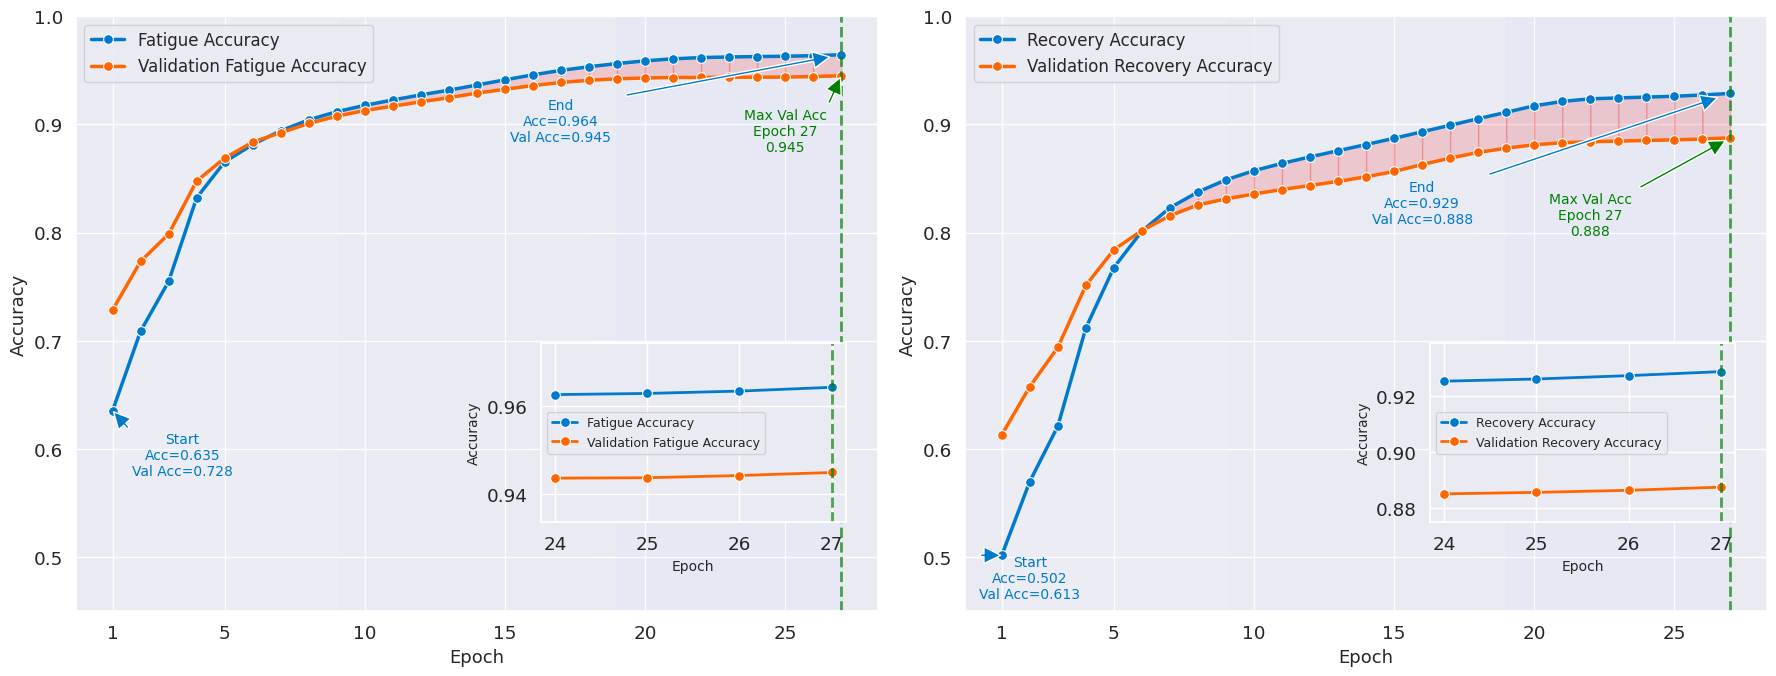

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

epochs = np.arange(1, 28)

fatigue_acc = np.array([
    0.6353, 0.7824, 0.8467, 0.8672, 0.8822, 0.8947, 0.9056, 0.9122, 0.9175, 0.9231,
    0.9271, 0.9316, 0.9362, 0.9413, 0.9460, 0.9501, 0.9536, 0.9562, 0.9588, 0.9612,
    0.9618, 0.9623, 0.9628, 0.9630, 0.9631, 0.9644, 0.9656
])

val_fatigue_acc = np.array([
    0.7284, 0.8184, 0.8491, 0.8753, 0.8823, 0.8932, 0.9015, 0.9078, 0.9134, 0.9173,
    0.9198, 0.9254, 0.9289, 0.9324, 0.9359, 0.9394, 0.9409, 0.9421, 0.9433, 0.9433,
    0.9434, 0.9435, 0.9437, 0.9437, 0.9438, 0.9452, 0.9458
])

recovery_acc = np.array([
    0.5017, 0.6381, 0.7233, 0.7739, 0.8058, 0.8242, 0.8387, 0.8497, 0.8578, 0.8642,
    0.8698, 0.8759, 0.8813, 0.8869, 0.8932, 0.8995, 0.9048, 0.9115, 0.9172, 0.9228,
    0.9237, 0.9244, 0.9253, 0.9260, 0.9267, 0.9289, 0.9303
])

val_recovery_acc = np.array([
    0.6131, 0.7021, 0.7663, 0.7850, 0.8012, 0.8193, 0.8263, 0.8310, 0.8362, 0.8397,
    0.8435, 0.8473, 0.8511, 0.8561, 0.8623, 0.8702, 0.8740, 0.8781, 0.8819, 0.8834,
    0.8839, 0.8845, 0.8853, 0.8857, 0.8861, 0.8875, 0.8891
])

def smooth(arr):
    return pd.Series(arr).rolling(window=3, min_periods=1).mean()

fatigue_acc_smooth = smooth(fatigue_acc)
val_fatigue_acc_smooth = smooth(val_fatigue_acc)

recovery_acc_smooth = smooth(recovery_acc)
val_recovery_acc_smooth = smooth(val_recovery_acc)

def plot_accuracy(ax, epochs, train_acc, val_acc, train_label, val_label, is_right_plot=False):
    max_val_idx = np.argmax(val_acc)
    max_val_epoch = epochs[max_val_idx]
    max_val_value = val_acc[max_val_idx]

    ax.axvspan(1, 9, color="#f0f8ff", alpha=0.2)
    ax.axvspan(10, 18, color="#e6f2ff", alpha=0.15)
    ax.axvspan(19, 27, color="#cce0ff", alpha=0.1)

    sns.lineplot(x=epochs, y=train_acc, marker='o', color='#007acc', label=train_label,
                 linewidth=2.5, markersize=7, ax=ax)
    sns.lineplot(x=epochs, y=val_acc, marker='o', color='#ff6600', label=val_label,
                 linewidth=2.5, markersize=7, ax=ax)

    for i in range(len(epochs) - 1):
        if val_acc[i] < train_acc[i]:
            ax.fill_between(epochs[i:i+2], val_acc[i:i+2], train_acc[i:i+2], color='red', alpha=0.15)

    ax.axvline(max_val_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)

    # Annotation positions — all below lines
    # Left plot annotations
    if not is_right_plot:
        start_text_pos = (epochs[0] + 2.5, train_acc.iloc[0] - 0.06)
        max_val_text_pos = (max_val_epoch - 2, max_val_value - 0.07)
        end_text_pos = (epochs[-1] - 10, train_acc.iloc[-1] - 0.08)
    else:
        # Right plot annotations moved left & below to fit inside
        start_text_pos = (epochs[0] + 1, train_acc.iloc[0] - 0.04)
        max_val_text_pos = (max_val_epoch - 5, max_val_value - 0.09)
        end_text_pos = (epochs[-1] - 11, train_acc.iloc[-1] - 0.12)

    ax.annotate(f'Start\nAcc={train_acc.iloc[0]:.3f}\nVal Acc={val_acc.iloc[0]:.3f}',
                xy=(epochs[0], train_acc.iloc[0]), xytext=start_text_pos,
                ha='center',
                arrowprops=dict(facecolor='#007acc', shrink=0.05, width=2),
                fontsize=10, color='#007acc')

    ax.annotate(f'Max Val Acc\nEpoch {max_val_epoch}\n{max_val_value:.3f}',
                xy=(max_val_epoch, max_val_value), xytext=max_val_text_pos,
                ha='center',
                arrowprops=dict(facecolor='green', shrink=0.05, width=2),
                fontsize=10, color='green')

    ax.annotate(f'End\nAcc={train_acc.iloc[-1]:.3f}\nVal Acc={val_acc.iloc[-1]:.3f}',
                xy=(epochs[-1], train_acc.iloc[-1]), xytext=end_text_pos,
                ha='center',
                arrowprops=dict(facecolor='#007acc', shrink=0.05, width=2),
                fontsize=10, color='#007acc')

    ax.set_xlabel('Epoch', fontsize=13)
    ax.set_ylabel('Accuracy', fontsize=13)
    ax.legend(fontsize=12)
    ax.set_xticks([1, 5, 10, 15, 20, 25])
    ax.set_ylim(0.45, 1.0)
    ax.grid(True)

    # Inset zoom bottom right corner
    inset_ax = ax.inset_axes([0.58, 0.15, 0.38, 0.3])

    window = 3
    max_start = max(max_val_idx - window, 0)
    max_end = min(max_val_idx + window + 1, len(epochs))

    sns.lineplot(x=epochs[max_start:max_end], y=train_acc.iloc[max_start:max_end], marker='o',
                 color='#007acc', label=train_label, ax=inset_ax, linewidth=2, markersize=7)
    sns.lineplot(x=epochs[max_start:max_end], y=val_acc.iloc[max_start:max_end], marker='o',
                 color='#ff6600', label=val_label, ax=inset_ax, linewidth=2, markersize=7)

    inset_ax.axvline(max_val_epoch, color='green', linestyle='--', linewidth=2, alpha=0.7)
    inset_ax.set_xticks(epochs[max_start:max_end])
    inset_ax.set_ylim(min(min(train_acc.iloc[max_start:max_end]), min(val_acc.iloc[max_start:max_end])) - 0.01,
                      max(max(train_acc.iloc[max_start:max_end]), max(val_acc.iloc[max_start:max_end])) + 0.01)
    inset_ax.set_xlabel('Epoch', fontsize=10)
    inset_ax.set_ylabel('Accuracy', fontsize=10)
    inset_ax.legend(fontsize=9)
    inset_ax.grid(True)


plt.figure(figsize=(18, 7))

ax1 = plt.subplot(1, 2, 1)
plot_accuracy(ax1, epochs, fatigue_acc_smooth, val_fatigue_acc_smooth,
              'Fatigue Accuracy', 'Validation Fatigue Accuracy')

ax2 = plt.subplot(1, 2, 2)
plot_accuracy(ax2, epochs, recovery_acc_smooth, val_recovery_acc_smooth,
              'Recovery Accuracy', 'Validation Recovery Accuracy', is_right_plot=True)

plt.tight_layout()
plt.show()


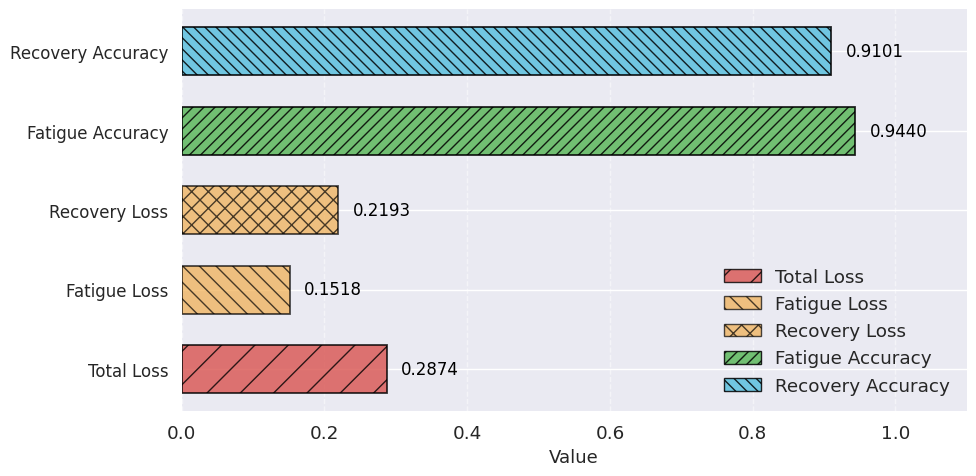

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Data
metrics = ['Total Loss', 'Fatigue Loss', 'Recovery Loss', 'Fatigue Accuracy', 'Recovery Accuracy']
values = [0.2874, 0.1518, 0.2193, 0.9440, 0.9101]

# Visual styles
colors = ['#d9534f', '#f0ad4e', '#f0ad4e', '#5cb85c', '#5bc0de']
hatches = ['/', '\\\\', 'xx', '///', '\\\\\\']
alphas = [0.8, 0.7, 0.7, 0.85, 0.85]

plt.figure(figsize=(10, 5))

# Adjust bar properties
bar_height = 0.18  # slightly thinner
# Reduce vertical spacing: use tighter y-positions
y_pos = [i * 0.3 for i in range(len(metrics))]  # compress spacing

# Draw bars
for i in range(len(metrics)):
    plt.barh(
        y=y_pos[i],
        width=values[i],
        height=bar_height,
        color=colors[i],
        hatch=hatches[i],
        edgecolor='black',
        alpha=alphas[i],
        linewidth=1.3
    )
    # Annotate values at end of bar
    plt.text(
        values[i] + 0.02, y_pos[i],
        f'{values[i]:.4f}',
        va='center', ha='left',
        fontsize=12, color='black'
    )

# Axis settings
plt.yticks(ticks=y_pos, labels=metrics, fontsize=12)
plt.xlabel('Value', fontsize=13)
#plt.title('Model Performance Metrics', fontsize=16, fontweight='bold', pad=20)
plt.xlim(0, 1.1)

# Grid and style
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)

# Legend
legend_patches = [
    mpatches.Patch(facecolor=colors[i], hatch=hatches[i], edgecolor='black',
                   label=metrics[i], alpha=alphas[i])
    for i in range(len(metrics))
]
plt.legend(handles=legend_patches, loc='lower right', frameon=False)

plt.tight_layout()
plt.show()


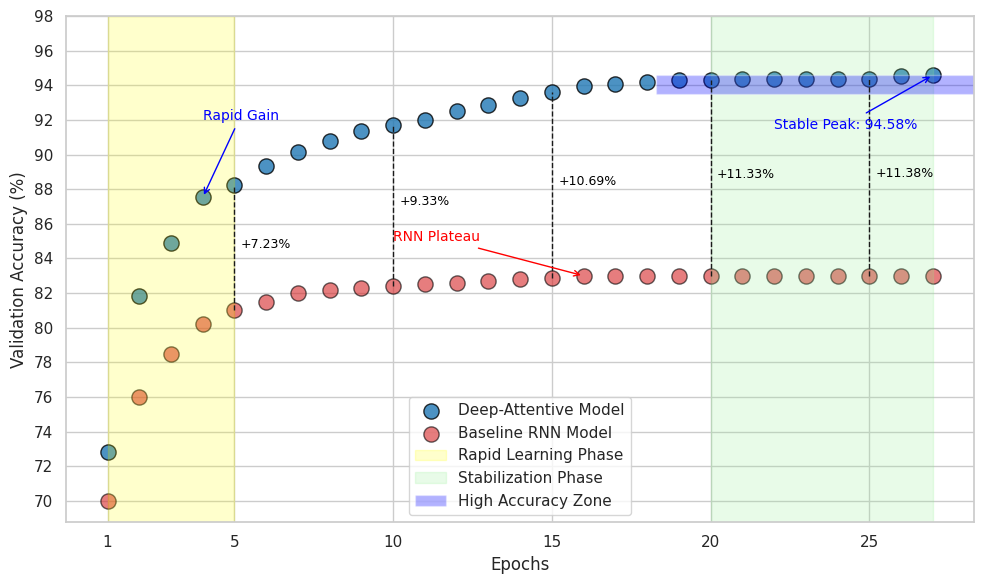

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
epochs = list(range(1, 28))
deep_attentive_acc = [72.84, 81.84, 84.91, 87.53, 88.23, 89.32, 90.15, 90.78, 91.34,
                      91.73, 91.98, 92.54, 92.89, 93.24, 93.59, 93.94, 94.09, 94.21,
                      94.33, 94.33, 94.34, 94.35, 94.37, 94.37, 94.38, 94.52, 94.58]

rnn_model_acc = [70.00, 76.00, 78.50, 80.20, 81.00, 81.50, 82.00, 82.20, 82.30,
                 82.40, 82.50, 82.60, 82.70, 82.80, 82.90, 83.00, 83.00, 83.00,
                 83.00, 83.00, 83.00, 83.00, 83.00, 83.00, 83.00, 83.00, 83.00]

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Bubble plots
plt.scatter(epochs, deep_attentive_acc, s=120, c='tab:blue', label="Deep-Attentive Model", alpha=0.8, edgecolors='black')
plt.scatter(epochs, rnn_model_acc, s=120, c='tab:red', label="Baseline RNN Model", alpha=0.6, edgecolors='black')

# Highlight regions
plt.axvspan(1, 5, color='yellow', alpha=0.2, label='Rapid Learning Phase')
plt.axvspan(20, 27, color='lightgreen', alpha=0.2, label='Stabilization Phase')
plt.axhspan(93.5, 94.6, xmin=0.65, xmax=1.0, facecolor='blue', alpha=0.3, label='High Accuracy Zone')

# Annotations for trend
plt.annotate("Rapid Gain", xy=(4, deep_attentive_acc[3]), xytext=(4, 92),
             arrowprops=dict(arrowstyle="->", color='blue'), color='blue', fontsize=10)
plt.annotate("Stable Peak: 94.58%", xy=(27, deep_attentive_acc[-1]), xytext=(22, 91.5),
             arrowprops=dict(arrowstyle="->", color='blue'), color='blue', fontsize=10)
plt.annotate("RNN Plateau", xy=(16, rnn_model_acc[15]), xytext=(10, 85),
             arrowprops=dict(arrowstyle="->", color='red'), color='red', fontsize=10)

# Annotate every 5th point with difference
for i in range(4, len(epochs), 5):  # every 5th point (0-based indexing)
    epoch = epochs[i]
    acc_diff = round(deep_attentive_acc[i] - rnn_model_acc[i], 2)
    plt.plot([epoch, epoch], [rnn_model_acc[i], deep_attentive_acc[i]], 'k--', linewidth=1)
    plt.annotate(f"+{acc_diff}%",
                 xy=(epoch, (deep_attentive_acc[i] + rnn_model_acc[i]) / 2),
                 xytext=(epoch + 0.2, (deep_attentive_acc[i] + rnn_model_acc[i]) / 2),
                 fontsize=9, color='black')

# Axis settings
plt.xticks([1, 5, 10, 15, 20, 25])
plt.yticks(np.arange(70, 100, 2))
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Accuracy (%)", fontsize=12)
#plt.title("Validation Accuracy Comparison: Deep-Attentive vs Baseline RNN", fontsize=14, weight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
